## Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
![image.png](attachment:5a0e0d97-4380-4cb2-bf26-d0ab6ee7458a.png)

In [1]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/0.0.11.zip"

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.12dev'

## Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [3]:
wavelength =532.05 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, cut_off_intensity=2000)
df_Ne.head()

,Raman_shift (cm-1),Intensity,Ne emission line in air
1,818.558217,5000.0,556.27662
9,1116.945682,5000.0,565.66588
16,1310.338900,5000.0,571.92248
19,1398.773828,5000.0,574.82985
23,1447.423317,7000.0,576.44188


## Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for the line shift you have written down

In [28]:
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
                                      line1_shift=1310, line2_shift=1390,
                                     cut_off_intensity=2000)
ideal_split

,Ne_Split,Line_1,Line_2,Entered Pos Line 1,Entered Pos Line 2
0,88.434928,1310.3389,1398.773828,1310,1390


## Find your files

In [29]:
mypath=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\BenBlack'
filetype='head_csv'
# Put the common string you can in all your Ne lines here
ID_str='Ne'
file_ext='csv' # Will only take files of this type 
exclude_str='png' # Will exclude files of this type, sometimes images have same name
prefix=None # Leave as none unless witec appended a number
Ne_files=pf.get_Ne_files(path=mypath, file_ext=file_ext,
                         ID_str=ID_str, exclude_str=exclude_str, sort=True)

In [30]:
Ne_files

['003_Ne_02.csv', '003_Ne_03.csv']

## Select the first file you want to fit
- You can either do this numerically, or by specifiying the filename between ''

In [31]:
filename=Ne_files[0]  # Or you could put a string here, like 'NE1.txt' 

## Plot Ne lines to inspect

Biggest 6 peaks:


,pos,height
50,1444.342318,15381.666990
43,1395.931204,3967.000000
65,1563.844689,3620.333252
7,1113.926895,1986.333374
24,1216.749032,1514.000000
33,1307.388779,1247.000000


selected Peak 1 Pos
1307.388779
selected Peak 2 Pos
1395.931204


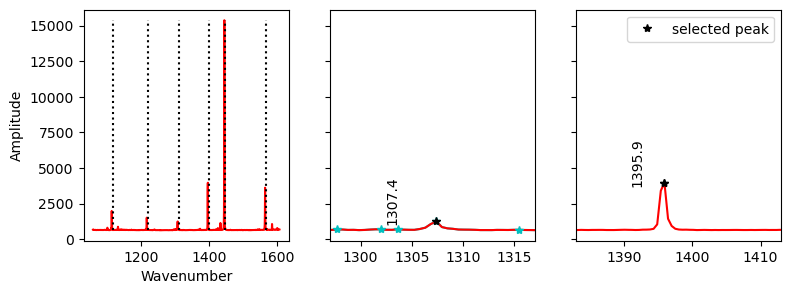

In [32]:
# Specify the approximate peak positions of the lines you are interested in
# If your drift is off the real positions, you'll have to tweak these numbers
peak1_cent=1307
peak2_cent=1398


Ne, df_sort_Ne_trim, nearest_1117, nearest_1447=pf.plot_Ne_lines(path=mypath, filename=filename, filetype=filetype, 
n_peaks=6, peak1_cent=peak1_cent, peak2_cent=peak2_cent,
height=10, threshold=0.6, distance=1, prominence=10, width=1, exclude_range_1=None,
exclude_range_2=None)

## Now tweak the fit for this 1 example
- Most important things, the number of peaks you want for 1117, and the offset for this peak (LH_offset_min)
- By default, the function applies the fit to all the points inside the outermost background positions. This can be trimmed using x_span_pk1_override, and x_span_pk2_override, 

## You can tweak parameters here
- The default parameters may work, you can see what those are here:

In [33]:
pf.Ne_peak_config()

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), x_range_baseline=20, y_range_baseline=200, amplitude=100, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

- You can also overwrite any of these, the most likely things you'll want to overwrite are the background positions, or the amplitude

In [34]:
Ne_Config=pf.Ne_peak_config(amplitude=500, LH_offset_mini=[2, 5], 
lower_bck_pk1=(-50, -30), upper_bck1_pk1=[20, 40], upper_bck2_pk1=[20, 40],
lower_bck_pk2=[-50, -40], upper_bck1_pk2=[10, 20], upper_bck2_pk2=[10, 20],
x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])
Ne_Config

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -30), upper_bck1_pk1=[20, 40], upper_bck2_pk1=[20, 40], lower_bck_pk2=[-50, -40], upper_bck1_pk2=[10, 20], upper_bck2_pk2=[10, 20], x_range_baseline=20, y_range_baseline=200, amplitude=500, x_range_peak=15, x_range_residual=7, LH_offset_mini=[2, 5], x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])

fitting a single peak, if you want the shoulder, do peaks_1117=2


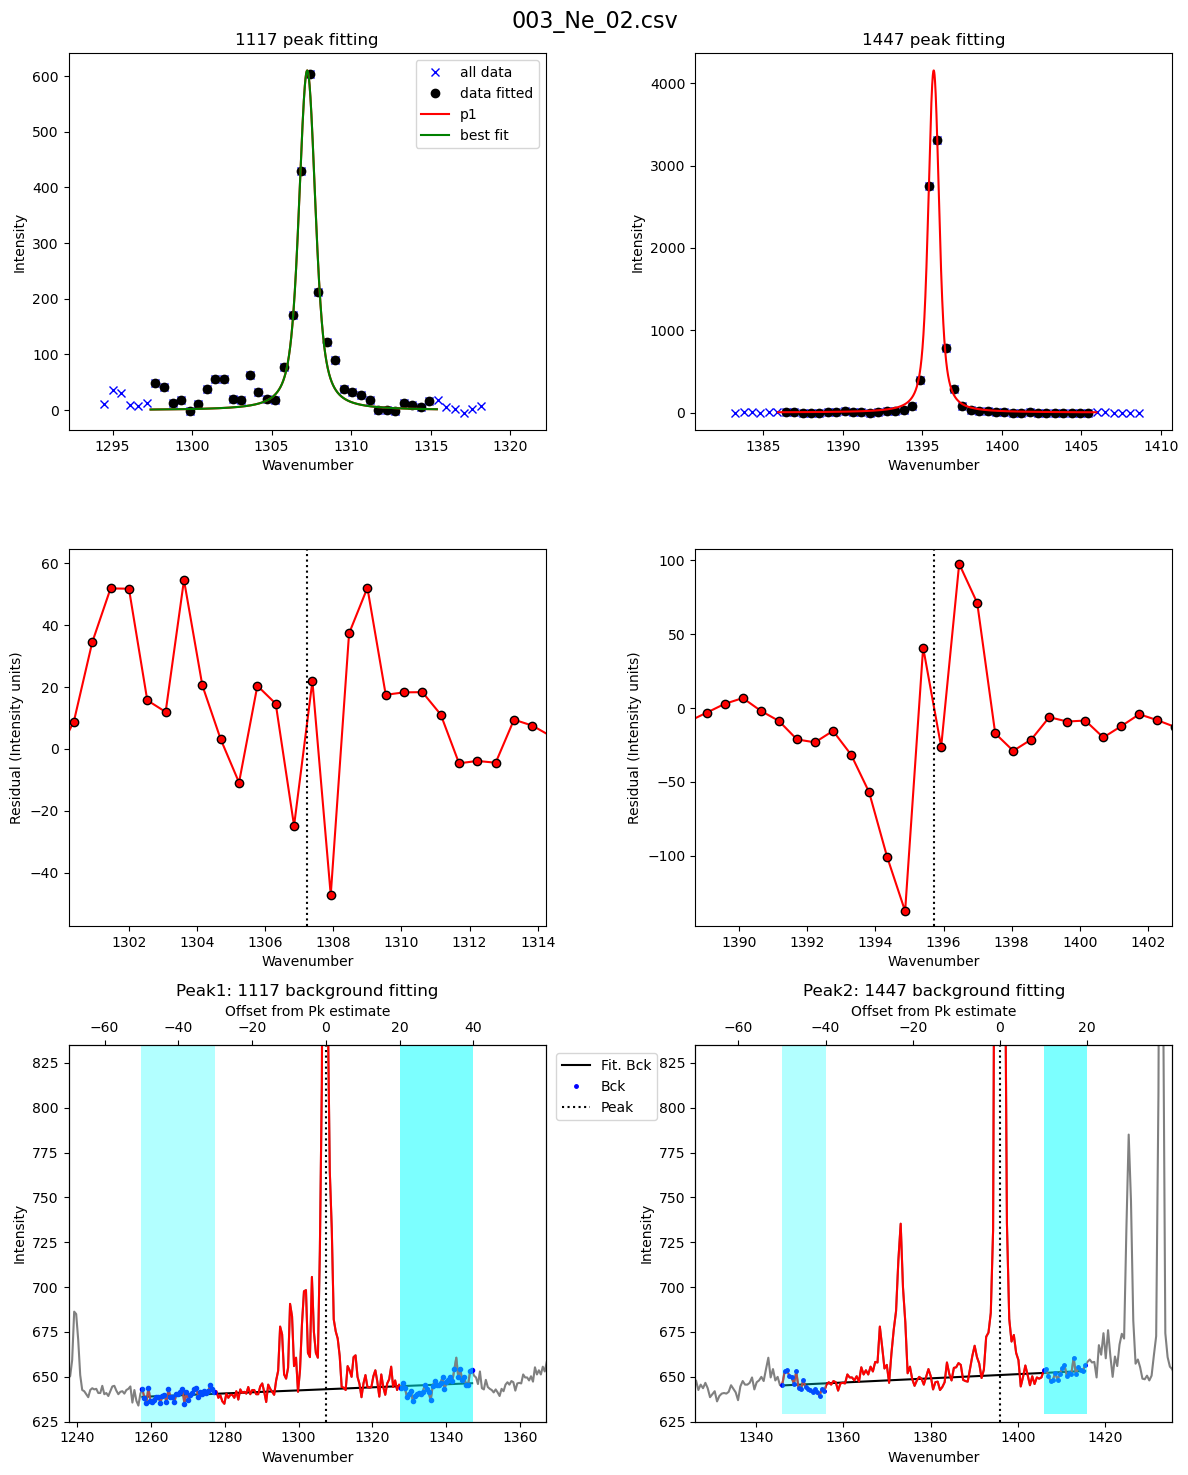

In [35]:
# You also need to set whether you want 1 peak or 2 for the LH diad
peaks_1=1

df_test, Ne_1117_reg_x_plot, Ne_1117_reg_y_plot=pf.fit_Ne_lines(  
    config=Ne_Config, peaks_1=peaks_1,
    Ne=Ne, filename=filename, path=mypath, prefix=prefix,
    Ne_center_1=nearest_1117, Ne_center_2=nearest_1447,
    DeltaNe_ideal=ideal_split['Ne_Split'])                                                                 
                                                                     
        
#config: Ne_peak_config=Ne_peak_config(),

## Now you can loop over all files using these parameters
- Most important thing you can change is plot_figure=False, much quicker, but wont save or show figures, plot_figure=True will)
- If you need, you can add other parameters in the loop here. 

working on 003_Ne_02.csv
fitting a single peak, if you want the shoulder, do peaks_1117=2


C:\Users\penny\AppData\Local\Temp\ipykernel_12872\1311343921.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on 003_Ne_03.csv
fitting a single peak, if you want the shoulder, do peaks_1117=2


C:\Users\penny\AppData\Local\Temp\ipykernel_12872\1311343921.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


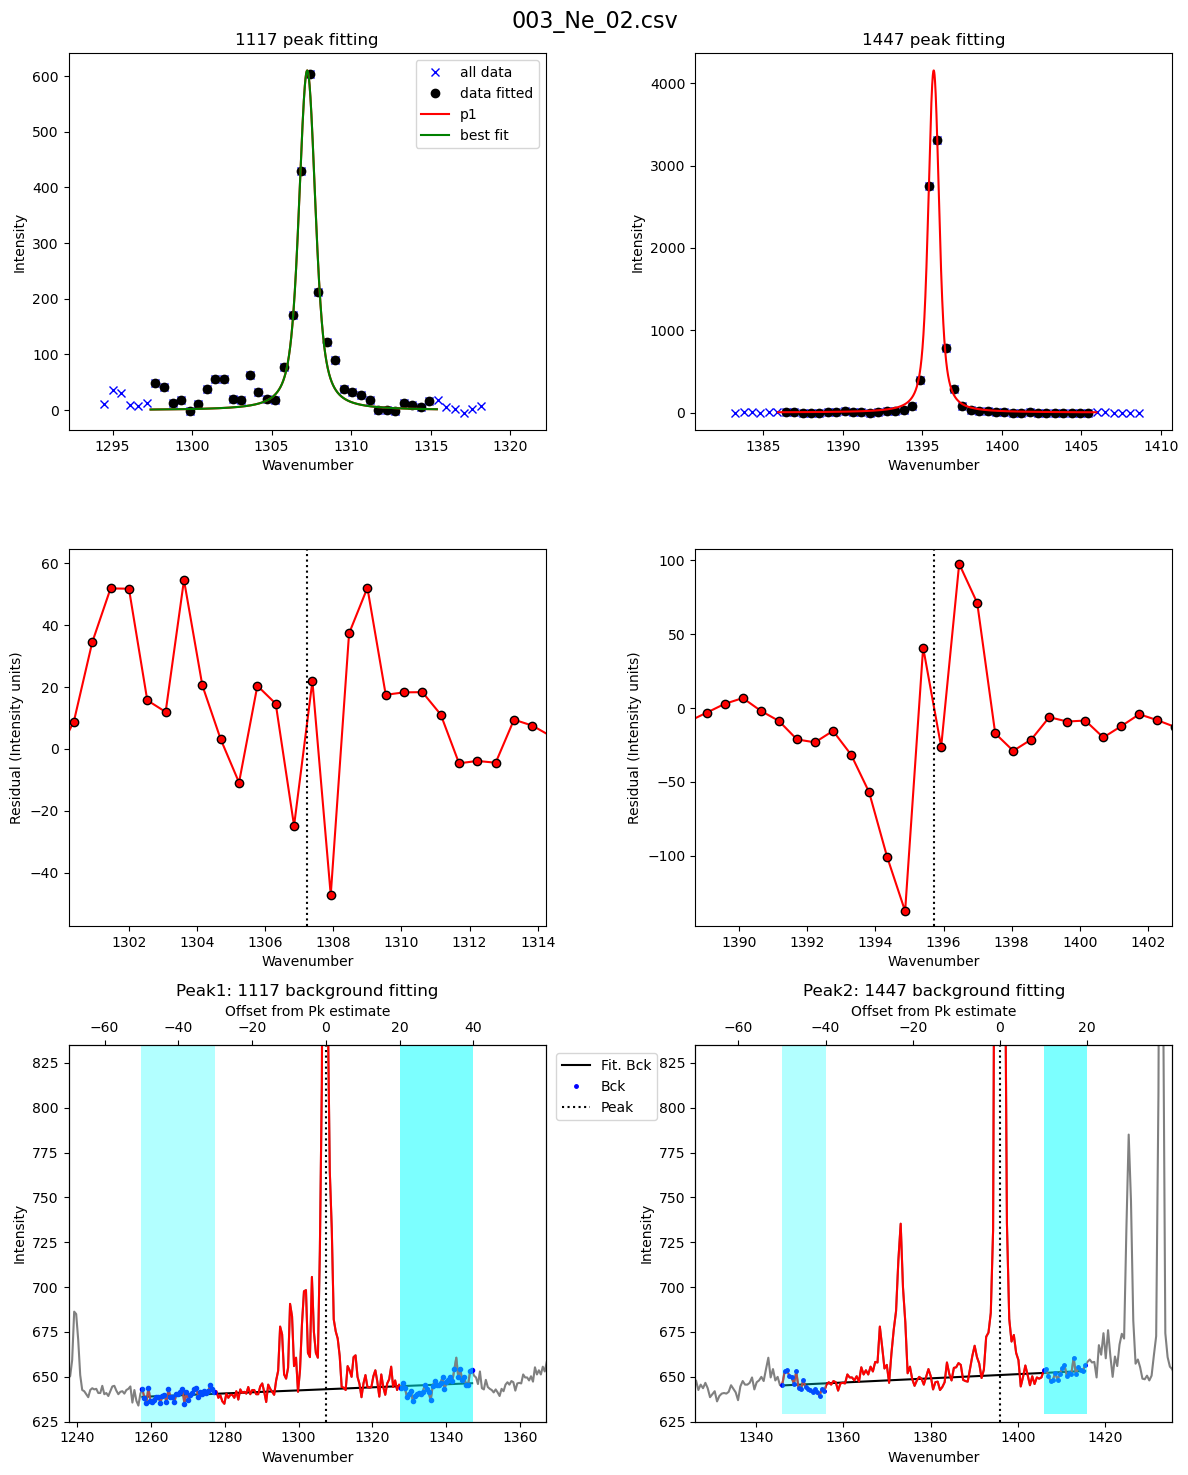

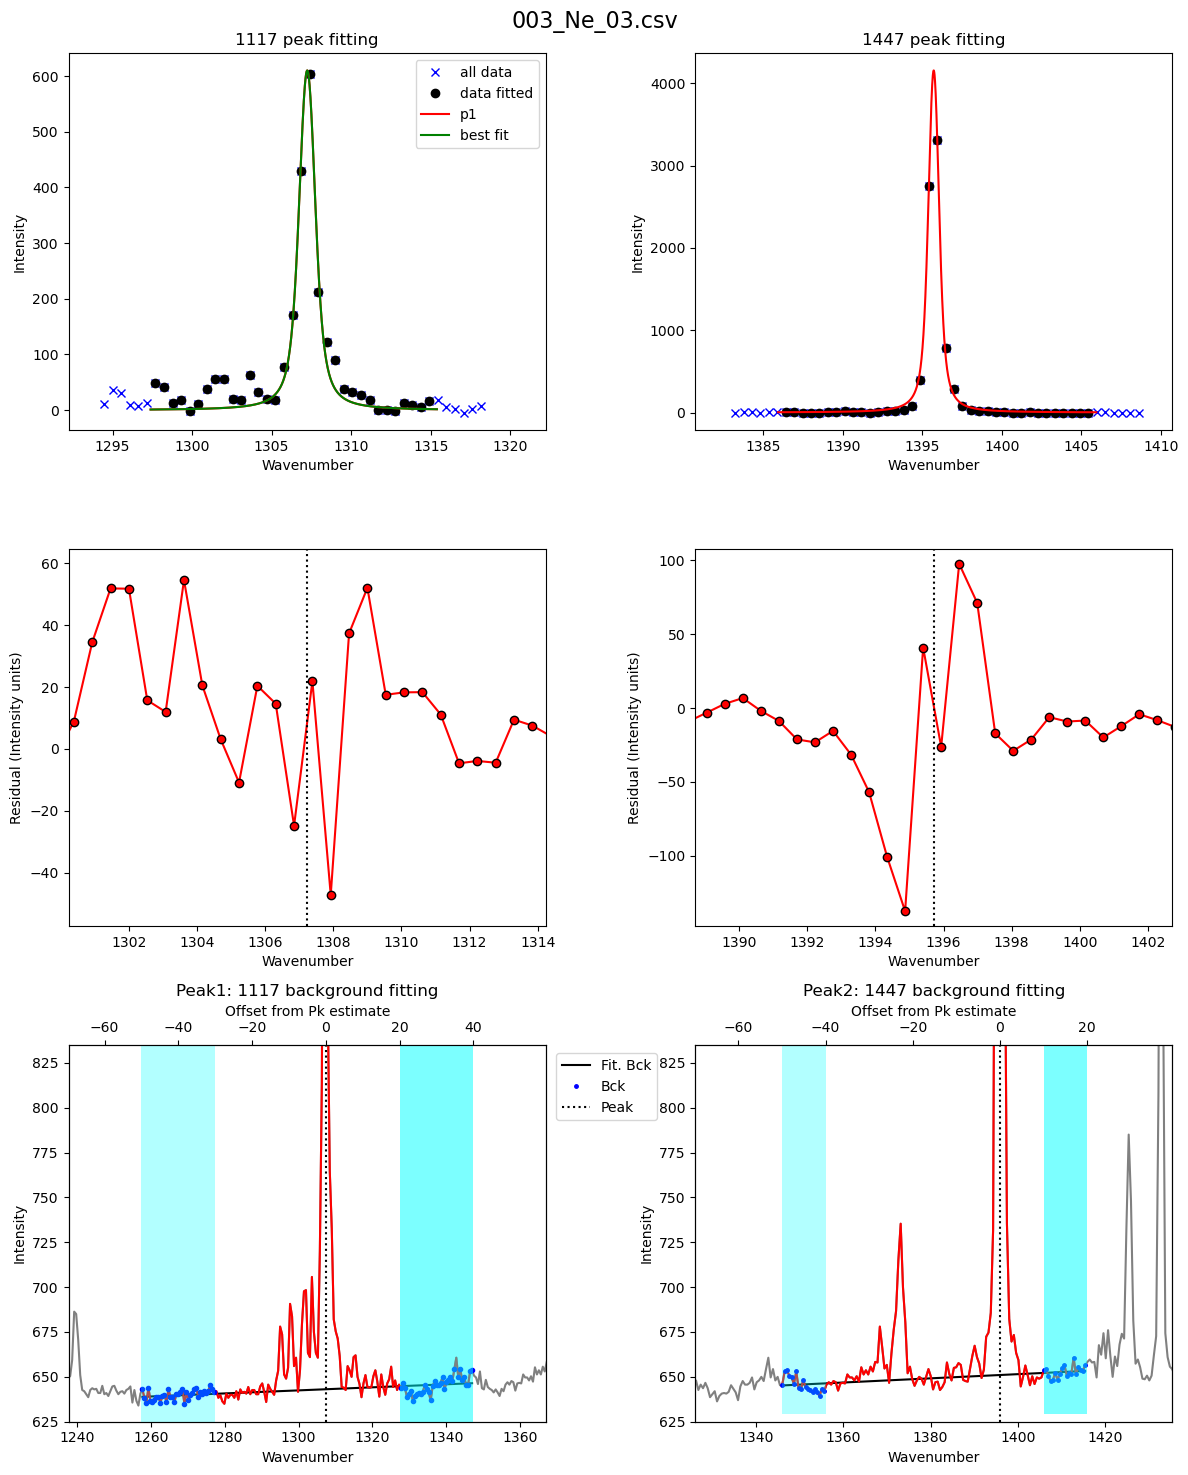

In [36]:
plot_figure=True # Means doesnt make figures, lot faster. 
save_excel=True # Saves to excel
save_clipboard=True # Copies to clipboard

df = pd.DataFrame([])
for i in range(0, len(Ne_files)):
    
    filename=Ne_files[i]
    Ne=pf.get_data(path=mypath, filename=filename, filetype=filetype)
    print('working on ' + str(Ne_files[i]))

#     data=pf.fit_Ne_lines(Ne=Ne, filename=filename, path=path, prefix=prefix,
                         
                         
# LH_offset_mini=LH_offset_mini, peaks_1=peaks_1, Ne_center_1=nearest_1117,
# lower_bck_pk1=[-50, -25], upper_bck1_pk1=[8, 13], upper_bck2_pk1=[50, 80],
# lower_bck_pk2=[-40, -30], upper_bck1_pk2=[15, 50], upper_bck2_pk2=[50, 80],                         
# Ne_center_2=nearest_1447, amplitude=amplitude, 
# x_range_baseline=x_range_baseline, y_range_baseline=y_range_baseline, 
# x_span_pk1_override=x_span_pk1_override,
# x_span_pk2_override=x_span_pk2_override, x_range_peak=x_range_peak,                         
# plot_figure=plot_figure, loop=True, DeltaNe_ideal=ideal_split['Ne_Split'])
    
    
    data, Ne_1117_reg_x_plot, Ne_1117_reg_y_plot=pf.fit_Ne_lines(  
    config=Ne_Config, peaks_1=peaks_1,
    Ne=Ne, filename=filename, path=mypath, prefix=prefix,
    Ne_center_1=nearest_1117, Ne_center_2=nearest_1447,
    DeltaNe_ideal=ideal_split['Ne_Split']) 


    df = df.append(data)


